# Nuclear segmentation with emerin ring and spot detection

Scripts to detect nuclei from 5d images (t,c,z,y,x) where channel 0 is green spots and channel 1 is red emerin rings.
Mostly based on scripts from Lucien Hinderling, with some modifications and cleanup by Jennifer Semple.

Nuclear segmentation carried out with Cellpose.
Spot detection carried out with pytrack.

**Inputs**:

raw_input_path and denoised_input_path for directories containing raw and denoised images and output_path where results will be put. raw_input_path is used to create a dataframe with paths to images and the following 
columns:

*filename	date	experiment	strain	protein	id  raw_filepath    denoised_filepath*

example line:

*20240915_1268_E_bean_15um	20240915	3d	1268	DPY27	DPY27_3d_20240915_1268_E_bean_15um	/mnt/external.data/MeisterLab/Dario/Imaging/DP...	/mnt/external.data/MeisterLab/Dario/Imaging/DP...*

the id column is used to name images in the output_path directories

**Outputs**:

segmentation masks (.tif files) in output_path/segmentation/

distance masks (.tif files) in output_path/edt/

nuclear measurements (.csv files) in output_path/nuclei/

intensity measurements for nuclei with arrays of intensity/distance from middle slice of each nuclear mask (.pkl files) in as well as other nuclear measurments and data are in output_path/dist/ 

qc plots of segmentation on original image (segmentation_XXX.pdf), individual masked nuclei (cropped_nuclei_XXX.pdf) in output_path/qc/

spot detection (.csv files, doesn't work very well) in output_path/spots/ with some qc in output_path/qc/spots*.pdf and spotGMM*.pdf

### Setting you might need to change

raw_input_path - should point to directory where the nd2 images are '/mnt/external.data/MeisterLab/Dario/SDC1/1273/20241108_hs'. 
Scripts assume the denoised images are one level down in N2V_sdc1_dpy27_mSG_emr1_mCh/denoised folder.
Scripts assume that the directory above the raw_input drive contains strain name, and the directory above that contains protein name.

output_path - create a directory for the analysis. results will be stored in a protein/strain/date structure same as in the raw_input_path.

Make sure file paths end with  '/'

If you are not working on the server, but rather locally on a mac with izbkingston mounted as an external drive, you need to change 'server = True' to False (currently this only works for mac externally mounted drives).

Set the channels for nuclear stain (nucChannel) and for spots (spotChannel) [currently 0 and 1 respectively] 


In [1]:
import napari
import torch
from skimage.measure import regionprops_table, regionprops
from skimage.color import label2rgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import cellpose
from cellpose import models
import edt
import glob
import os
import tqdm
from matplotlib_scalebar.scalebar import ScaleBar
import gc
import seaborn as sns
from sklearn.mixture import GaussianMixture
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter
import scipy.stats as stats
from scipy import optimize
from scipy.ndimage import map_coordinates #new
import bioio



#anisotropy = (3,1,1) # Relative scale of (Z,X,Y) axes now calculated inside scripts

nucChannel = 0 # red emerin rings
spotChannel = 1 # green spots
server = True # is the script running on the server or mounted on mac

def macMount(path): # tansforms server path to path for izbkingston mounted on mac
    newpath = path.replace('/mnt/','/Volumes/')
    return newpath



# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

pd.set_option('display.max_columns', None)

In [13]:
# on server

raw_input_path = '/mnt/external.data/MeisterLab/Dario/SDC1/1273/20240813_e/'
denoised_input_path = raw_input_path+'N2V_sdc1_dpy27_mSG_emr1_mCh/denoised/'

# extract identifying directories from raw_input_path
protein_strain_date = '/'.join(os.path.normpath(raw_input_path).split(os.sep)[-3:])
output_path = '/mnt/external.data/MeisterLab/mvolosko/image_project/sdc1/'+protein_strain_date+'/'


if(not server):
    raw_input_path = macMount(raw_input_path)
    output_path = macMount(output_path)


#new
if not os.path.exists(output_path+"/qc_plots"):
    os.makedirs(output_path+"/qc_plots")

if not os.path.exists(output_path+"/qc"):
    os.makedirs(output_path+"/qc")

if not os.path.exists(output_path+"/segmentation"):
    os.makedirs(output_path+"/segmentation")

if not os.path.exists(output_path+"/edt"):
    os.makedirs(output_path+"/edt")

if not os.path.exists(output_path+"/spots"):
    os.makedirs(output_path+"/spots")

if not os.path.exists(output_path+"/nuclei"):
    os.makedirs(output_path+"/nuclei")
    
if not os.path.exists(output_path+"/dist"):
    os.makedirs(output_path+"/dist")


raw_file_name_pattern = "/*.nd2"
denoised_file_name_pattern = "/*_n2v.tif"
raw_filepaths = sorted(glob.glob(raw_input_path + raw_file_name_pattern,recursive=True))
raw_filepaths = [filepath for filepath in raw_filepaths if '_bad.nd2' not in filepath]

print(f"Found {len(raw_filepaths)} *.nd2 files.")

Found 44 *.nd2 files.


Generate data frame of file paths with metadata

In [14]:
if(server): #only save if running on server
    df = pd.DataFrame()
    df['filename'] = [os.path.basename(filepath)[:-4] for filepath in raw_filepaths]
    tmpdate = [os.path.normpath(filepath).split(os.sep)[-2] for filepath in raw_filepaths]
    df['date'] = pd.Series([exp.split('_')[0] for exp in tmpdate])
    df['experiment'] = pd.Series([exp.split('_')[1] for exp in tmpdate])
    df['strain'] = [os.path.normpath(filepath).split(os.sep)[-3] for filepath in raw_filepaths]
    df['protein'] = [os.path.normpath(filepath).split(os.sep)[-4] for filepath in raw_filepaths]
    df['id'] = df['protein'] + '_' + df['experiment'] + '_' + df['filename'] 
    df['raw_filepath'] = raw_filepaths
    df['denoised_filepath'] = [denoised_input_path+filename+'_n2v.tif' for filename in df['filename']]
    df.to_csv(output_path+'fileList.csv',index=False)
else:
    df=pd.read_csv(output_path+'fileList.csv')
    for i in range(len(df)):
        df.at[i,'raw_filepath'] = macMount(df.at[i,'raw_filepath'])
        df.at[i,'denoised_filepath'] = macMount(df.at[i,'denoised_filepath'])


df

,filename,date,experiment,strain,protein,id,raw_filepath,denoised_filepath
0,20240813_1273_E_bean_15um_01,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_bean_15um_01,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
1,20240813_1273_E_bean_15um_02,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_bean_15um_02,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
2,20240813_1273_E_bean_15um_03,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_bean_15um_03,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
3,20240813_1273_E_bean_15um_04,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_bean_15um_04,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
4,20240813_1273_E_bean_15um_05,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_bean_15um_05,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
5,20240813_1273_E_bean_15um_06,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_bean_15um_06,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
6,20240813_1273_E_early_15um_01,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_early_15um_01,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
7,20240813_1273_E_early_15um_02,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_early_15um_02,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
8,20240813_1273_E_early_15um_03,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_early_15um_03,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...
9,20240813_1273_E_early_15um_04,20240813,e,1273,SDC1,SDC1_e_20240813_1273_E_early_15um_04,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...,/mnt/external.data/MeisterLab/Dario/SDC1/1273/...


Load model

In [15]:
torch.cuda.device(0)
model_path='/mnt/external.data/MeisterLab/lhinder/segmentation_3d_anja/code/worms_1000epochs_v0'
if(not server):
    model_path = macMount(model_path)

if torch.cuda.is_available():
    print("GPU is available")
    model = models.CellposeModel(pretrained_model=model_path, gpu=True, device =torch.device('cuda:0'))
else:
    print("Only CPU is available")
    model = models.CellposeModel(pretrained_model=model_path, gpu=False)


# no gpu, from local machine with izbkingston mounted 
#model = models.CellposeModel(pretrained_model='/Volumes/external.data/MeisterLab/lhinder/segmentation_3d_anja/code/worms_1000epochs_v0')

GPU is available


/home/mvolosko/miniconda3/envs/lhcellpose/lib/python3.10/site-packages/cellpose/resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fi

## ND2 to tiff transforamtion raw

## Functions for nuclear segmentation and qc

In [16]:
# Disable do_3D, there is a bug. 2D and stitching with overlap works much better.
# Takes around 7min for the whole image on the macbook
def segment_nuclei(img, model):
    ''' use pytorch cellpose model to segment nuclei'''
    masks,flows,styles = model.eval(img,do_3D=False,stitch_threshold=0.3,cellprob_threshold =0,diameter =36)
    return masks,flows,styles


def calc_distance_mask(masks,anisotropy):
    '''Calculate the distance map from the nuclei-edge towards the center of nucleus'''
    masks_edt = edt.edt(masks,anisotropy = anisotropy)
    return masks_edt




def plot_qc_nuclei_crop(df, index, df_region_props, img, t=0, display = False, seed=1):
    '''Plot a cropped region of a random sample of 10 nuclei from each image'''
    nb_nuc = 10
    np.random.seed(seed)
    indices_to_sample = np.random.choice(range(len(df_region_props)),size = nb_nuc,replace = False)
    # sort indeces in descending order of area

    widths=[df_region_props['image'][i].shape[1] for i in indices_to_sample]

    fig, axs = plt.subplots(nrows = 2, ncols = nb_nuc, figsize = (15,5),dpi = 250, 
                            sharex=False, sharey=False, width_ratios=widths)
    fig.suptitle(f'Cropped nuclei {df.id.iloc[index]}', fontsize=16)

    for i,sample in enumerate(indices_to_sample):
        intensity_image = df_region_props['intensity_image'][sample][:,:,:,spotChannel] #show first spot channel
        image = df_region_props['image'][sample]
        mx = np.ma.masked_array(intensity_image,mask = ~image)
        z_height = image.shape[0] 
        axs[0,i].imshow(mx[int(z_height/2)])
        axs[0,i].spines['top'].set_visible(False)
        axs[0,i].spines['right'].set_visible(False)
        axs[0,i].spines['bottom'].set_visible(False)
        axs[0,i].spines['left'].set_visible(False)
        axs[0,i].get_xaxis().set_ticks([])
        axs[0,i].get_yaxis().set_ticks([])

    for i,sample in enumerate(indices_to_sample):
        intensity_image = df_region_props['intensity_image'][sample][:,:,:,nucChannel] #show second nuclear channel
        image = df_region_props['image'][sample]
        mx = np.ma.masked_array(intensity_image,mask = ~image)
        z_height = image.shape[0]
        axs[1,i].imshow(mx[int(z_height/2)])
        axs[1,i].spines['top'].set_visible(False)
        axs[1,i].spines['right'].set_visible(False)
        axs[1,i].spines['bottom'].set_visible(False)
        axs[1,i].spines['left'].set_visible(False)
        axs[1,i].get_xaxis().set_ticks([])
        axs[1,i].get_yaxis().set_ticks([])

        if i == nb_nuc-1:
            scalebar = ScaleBar(0.065, "um", length_fraction=1, box_alpha=0.7,color='black',location='lower right',height_fraction = 0.05,border_pad =-1)
            axs[1,i].add_artist(scalebar)

    #plt.tight_layout()
    fig.savefig(output_path + 'qc/cropped_nuclei_'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.pdf')
    if display == False:
        plt.close()
    else:
        plt.show()


def plot_single_nucleus_crop(df, index, df_region_props, nuc_index, img):
    '''Plot a cropped region of a particular nucleus'''

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (3,1.5),dpi = 250, sharey=True)
    fig.suptitle(f'{df.id.iloc[index]}', fontsize=6)

    intensity_image = df_region_props['intensity_image'][nuc_index][:,:,:,spotChannel] #show first spot channel
    image = df_region_props['image'][nuc_index]
    mx = np.ma.masked_array(intensity_image, mask = ~image)
    z_height = image.shape[0] 
    axs[0].imshow(mx[int(z_height/2)])
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].get_xaxis().set_ticks([])
    axs[0].get_yaxis().set_ticks([])


    intensity_image = df_region_props['intensity_image'][nuc_index][:,:,:,nucChannel] #show second nuclear channel
    image = df_region_props['image'][nuc_index]
    mx = np.ma.masked_array(intensity_image, mask = ~image)
    z_height = image.shape[0]
    axs[1].imshow(mx[int(z_height/2)])
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].get_xaxis().set_ticks([])
    axs[1].get_yaxis().set_ticks([])


    scalebar = ScaleBar(0.065, "um", length_fraction=1, box_alpha=0.7,color='black',location='lower right',height_fraction = 0.05,border_pad =-1)
    axs[1].add_artist(scalebar)

    plt.show()


def plot_qc_segmentation_xyz(img, masks, index, df, t=0, display_plot=False, plotContours=False):
    '''Plot a 2x3 grid of xy, xz, yz slices of the image and the corresponding segmentation'''
    nucChannel = 0
    num_z=img.shape[1]
    num_y=img.shape[2]
    num_x=img.shape[3]
    nlabel=100

    fig = plt.figure(layout='constrained',dpi=450,figsize = (10,10))
    fig.suptitle(f'Segmentation for {df.id.iloc[index]}', fontsize=10)
    subfigs = fig.subfigures(2, 1, wspace=0.1)

    axsTop = subfigs[0].subplots(2, 3,sharex=True, sharey=True)
    #xy
    axsTop[0,0].imshow(label2rgb(masks[int(num_z*0.3),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,0].set_title('z='+str(int(num_z*0.3)), fontsize=8)
    axsTop[0,1].imshow(label2rgb(masks[int(num_z*0.5),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,1].set_title('z='+str(int(num_z*0.5)), fontsize=8)
    axsTop[0,2].imshow(label2rgb(masks[int(num_z*0.7),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,2].set_title('z='+str(int(num_z*0.7)), fontsize=8)

    axsTop[1,0].imshow(img[nucChannel,int(num_z*0.3),:,:],cmap = 'gray_r')
    axsTop[1,1].imshow(img[nucChannel,int(num_z*0.5),:,:],cmap = 'gray_r')
    axsTop[1,2].imshow(img[nucChannel,int(num_z*0.7),:,:],cmap = 'gray_r')

    if plotContours:
        axsTop[1,0].contour(masks[int(num_z*0.3),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,1].contour(masks[int(num_z*0.5),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,2].contour(masks[int(num_z*0.7),:,:], [0.5], linewidths=0.5, colors='r')



    for axss in axsTop:
        for ax in axss:
            #ax.set_xlim(0,num_x)
            #ax.set_ylim(0,num_y)
            ax.set_xticks([])
            ax.set_yticks([])

    axsBottom = subfigs[1].subplots(4, 3,sharex=True,sharey=True)
    #xz
    axsBottom[0,0].imshow(label2rgb(masks[:,int(num_y*0.3),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,0].set_title('y='+str(int(num_y*0.3)), fontsize=8)
    axsBottom[0,1].imshow(label2rgb(masks[:,int(num_y*0.5),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,1].set_title('y='+str(int(num_y*0.5)), fontsize=8)
    axsBottom[0,2].imshow(label2rgb(masks[:,int(num_y*0.7),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,2].set_title('y='+str(int(num_y*0.7)), fontsize=8)

    axsBottom[1,0].imshow(img[nucChannel,:,int(num_y*0.3),:],cmap = 'gray_r')
    axsBottom[1,1].imshow(img[nucChannel,:,int(num_y*0.5),:],cmap = 'gray_r')
    axsBottom[1,2].imshow(img[nucChannel,:,int(num_y*0.7),:],cmap = 'gray_r')

    if plotContours:
        axsBottom[1,0].contour(masks[:,int(num_y*0.3),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,1].contour(masks[:,int(num_y*0.5),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,2].contour(masks[:,int(num_y*0.7),:], [0.5], linewidths=0.5, colors='r')


    #yz
    axsBottom[2,0].imshow(label2rgb(masks[:,:,int(num_x*0.3)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,0].set_title('x='+str(int(num_x*0.3)), fontsize=8)
    axsBottom[2,1].imshow(label2rgb(masks[:,:,int(num_x*0.5)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,1].set_title('x='+str(int(num_x*0.5)), fontsize=8)
    axsBottom[2,2].imshow(label2rgb(masks[:,:,int(num_x*0.7)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,2].set_title('x='+str(int(num_x*0.7)), fontsize=8)

    axsBottom[3,0].imshow(img[nucChannel,:,:,int(num_x*0.3)],cmap = 'gray_r')
    axsBottom[3,1].imshow(img[nucChannel,:,:,int(num_x*0.5)],cmap = 'gray_r')
    axsBottom[3,2].imshow(img[nucChannel,:,:,int(num_x*0.7)],cmap = 'gray_r')

    if plotContours:
        axsBottom[3,0].contour(masks[:,:,int(num_x*0.3)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,1].contour(masks[:,:,int(num_x*0.5)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,2].contour(masks[:,:,int(num_x*0.7)], [0.5], linewidths=0.5, colors='r')

    for axss in axsBottom:
        for ax in axss:
            #ax.set_ylim(0,num_z)
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    if display_plot:
        plt.show()
    else:
        fig.savefig(output_path + 'qc/segmentation_'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.png')
        plt.close()

In [17]:
# Run the segmentation script on all images (reserve more than 24GB!)
#this produces segmentation, segmentation_qc and edt files
def run_nuclear_segmentation(indices, df, rerun=False):
    '''Run the segmentation on all images in the dataframe'''
    for index in tqdm.tqdm(indices):
        if rerun or not os.path.exists(output_path+'edt/'+df.id.iloc[index]+'_t0.tif'):
            # get anisotropy from raw image metadata
            img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
            ZvX = np.round(img_5d.physical_pixel_sizes.Z/img_5d.physical_pixel_sizes.X,0)
            anisotropy = (ZvX,1,1)
            # Load the denoised data
            img_5d = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
            for t in range(img_5d.dims.T):
                img = img_5d.get_image_data("CZYX", T=t)

                # Segment nuclei 
                masks,flows,styles = segment_nuclei(img[nucChannel,:,:,:],model) # Run the segmentation
                plot_qc_segmentation_xyz(img,masks,index, df, t, display_plot = False)                         # Create qc plot
                OmeTiffWriter.save(masks, output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif')

                del flows
                del styles
                gc.collect()
                
                # Calculate edt 
                masks_edt = calc_distance_mask(masks,anisotropy)
                OmeTiffWriter.save(masks_edt, output_path+'edt/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif')

                del masks
                del masks_edt
                gc.collect()
                continue


In [18]:
## read images
## crop the nuclei slices
## calculate EDT transform
## for each nuclei loop over all distances (1:40) and take mean
## array of distance/intensity measurements are taken only for middle slice of mask (?)

## nucleus_id | nucleus volume | [1:20] mean intensities | group | ...


def run_dist_analysis(indices,df):
    '''Run the distance analysis on all images in the dataframe'''
    for index in tqdm.tqdm(indices):
        
        df_nuclei = pd.DataFrame()
        print(df.iloc[index].raw_filepath)

        img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
        # calculate anisotropy from raw image metadata
        ZvX = np.round(img_5d.physical_pixel_sizes.Z/img_5d.physical_pixel_sizes.X,0)

        for t in range(img_5d.dims.T):
            img = img_5d.get_image_data("ZYXC", T=t)

            masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
            masks = masks.get_image_data("ZYX", T=0, C=0)
            
            df_region_props = regionprops_table(masks,img, properties = ['label', 'area','centroid','MajorAxisLength','solidity','image','intensity_image'])
            df_region_props = pd.DataFrame(df_region_props)

            if len(df_region_props)>=10:
                plot_qc_nuclei_crop(df, index, df_region_props, img, t=t, display = False) 

            for i in range(len(df_region_props)):
                df_nuclei_temp = pd.DataFrame()

                intensity_image_spots = df_region_props['intensity_image'][i][:,:,:,spotChannel] #show spot channel
                intensity_image_nuclei = df_region_props['intensity_image'][i][:,:,:,nucChannel] #show nuclear ring channel

                image = df_region_props['image'][i]  # binary 3d mask

                # Extract the intensity per distance
                mx_spots = np.ma.masked_array(intensity_image_spots, mask = ~image) # 3d masked spot channel
                mx_nuclei = np.ma.masked_array(intensity_image_nuclei,mask = ~image) # 3d masked nuclear ring channel
                mx_mask = np.ma.masked_array(image,mask = ~image)  # 3d masked binary mask

                z_height = image.shape[0]

                slice_spots = mx_spots[int(z_height/2)]
                slice_nuclei = mx_nuclei[int(z_height/2)]
                slice_mask = mx_mask[int(z_height/2)]

                slice_mask_edt = edt.edt(slice_mask)
                slice_mask_edt = np.ma.masked_array(slice_mask_edt, mask = ~(slice_mask_edt>0)) 

                results = regionprops_table(slice_mask_edt.astype('int'),slice_nuclei,properties=['label','intensity_mean'])
                intensity_dist_nuclei = results['intensity_mean']

                results = regionprops_table(slice_mask_edt.astype('int'),slice_spots,properties=['label','intensity_mean'])
                intensity_dist_spots = results['intensity_mean']

                dist = results['label']

                df_nuclei_temp['label']  = [df_region_props.label.iloc[i]]
                df_nuclei_temp['bb_dimZ']  = [mx_spots.shape[0]]
                df_nuclei_temp['bb_dimY']  = [mx_spots.shape[1]]
                df_nuclei_temp['bb_dimX']  = [mx_spots.shape[2]]
                df_nuclei_temp['centroid_z'] = df_region_props['centroid-0'][i]
                df_nuclei_temp['centroid_y'] = df_region_props['centroid-1'][i]
                df_nuclei_temp['centroid_x'] = df_region_props['centroid-2'][i]
                df_nuclei_temp['major_axis_length'] = df_region_props['MajorAxisLength'][i]
                df_nuclei_temp['solidity'] = df_region_props['solidity'][i]
                df_nuclei_temp['mean'] = [np.ma.mean(mx_spots)]
                df_nuclei_temp['median'] = [np.ma.median(mx_spots)]
                df_nuclei_temp['std']=  [np.ma.std(mx_spots)]
                df_nuclei_temp['sum']= [np.ma.sum(mx_spots)]
                df_nuclei_temp['variance']= [np.ma.var(mx_spots)]
                df_nuclei_temp['max'] = [np.ma.max(mx_spots)]
                df_nuclei_temp['min'] = [np.ma.min(mx_spots)]
                df_nuclei_temp['volume'] = [np.sum(np.invert(mx_spots.mask))]
                df_nuclei_temp['id'] = [df.id.iloc[index]]
                df_nuclei_temp['timepoint'] = [t]
                df_nuclei_temp['intensity_dist_nuclei'] = [intensity_dist_nuclei]  # this is the emerin ring channel intensity on central slice
                df_nuclei_temp['intensity_dist_spots'] = [intensity_dist_spots] # this is the spot channel but not actual detected spots
                df_nuclei_temp['intensity_dist'] = [dist]  # this is the distance from the edge of the nucleus
                df_nuclei_temp['zproj_spots'] = [np.max(intensity_image_spots[:,:,:], axis = 0)]
                df_nuclei_temp['zproj_nuclei'] = [np.max(intensity_image_nuclei[:,:,:], axis = 0)]
                df_nuclei_temp['anisotropy'] = [ZvX]

                df_nuclei = pd.concat([df_nuclei,df_nuclei_temp])

        # save as pickle because has array stored in Dataframe
        df_nuclei.to_pickle(output_path+'dist/'+df.id.iloc[index]+'.pkl') # Back up the DF for this FOV

        # save with metadata as csv for simple viewing 
        df_nuclei_for_csv = pd.merge(df_nuclei,df,on='id',how='left')
        df_nuclei_for_csv.drop( columns = [ 'intensity_dist_nuclei','intensity_dist_spots','intensity_dist' ], axis=1, inplace=True)
        df_nuclei_for_csv.to_csv(output_path+'nuclei/'+df.id.iloc[index]+'.csv', index=False)



## Functions for spot detection and qc

In [19]:
from skimage import filters, restoration
from skimage.measure import regionprops_table
from sklearn.ensemble import IsolationForest

def preprocess_image(img, spot_channel=1, nucleus_channel=0):
    """Process 4D (ZYX) images with multiple channels"""
    # Extract channels
    spot_img = img[spot_channel]  # Green channel (spots)
    nuc_img = img[nucleus_channel]  # Red channel (nuclei)
    
    # Enhanced spot channel processing
    spot_processed = restoration.denoise_tv_chambolle(spot_img, weight=0.1)
    spot_processed = exposure.equalize_adapthist(spot_processed, kernel_size=15)
    
    # Nucleus-based masking
    nuc_mask = filters.apply_hysteresis_threshold(nuc_img, low=0.1, high=0.3)
    spot_processed[nuc_mask == 0] = 0  # Remove background
    
    return spot_processed, nuc_mask
    
def find_spots(img, spot_channel=1, diameter=(3,5,5), separation=(1,3,3)):
    """3D spot detection with channel alignment"""
    spot_img, nuc_mask = preprocess_image(img, spot_channel)
    
    features = tp.locate(
        spot_img,
        diameter=diameter,
        separation=separation,
        minmass=20,
        engine='numba',
        processes=4,  # Parallel processing
        characterize=True,
        threshold=0.3
    )
    
    # Add 3D position validation
    features = features[features['mass'] > features['mass'].quantile(0.25)]
    return features, spot_img, nuc_mask

def extract_spot_features(features, masks, masks_edt):
    '''For each spot get the label of the corresponding nucleus and distance to its envelope.'''
    
    #new
    # Ensure the mask is not inverted
    if np.max(masks) == 0:  # If the mask is inverted (all nuclei are 0)
        masks = np.where(masks > 0, 0, 1)  # Invert the mask

        # 3D distance transform
    masks_edt = distance_transform_edt(masks)
    
    features['nuclear_volume'] = np.sum(masks)
    features['nuclear_surface'] = np.sum(masks_edt == 1)
    
    # Add 3D spatial features
    features['z_ratio'] = features['z'] / masks.shape[0]
    features['radial_position'] = np.sqrt(
        (features['x'] - masks.shape[2]/2)**2 +
        (features['y'] - masks.shape[1]/2)**2
    )
    
    return features

#new changed signal_strength to 1.0
def filter_spots(features, measure='signal', filter_dist=True):
    """Advanced filtering using outlier detection"""
    # Initial filtering
    base_mask = (features[measure] > 0.001)
    if filter_dist:
        base_mask &= (features['dist'] > 0)
    
    # Train anomaly detector on good features
    clf = IsolationForest(contamination=0.1)
    X = features[['mass', 'size_z', 'eccentricity', 'signal_to_noise']]
    clf.fit(X)
    
    # Combine filters
    final_mask = base_mask & (clf.predict(X) == 1)
    
    return features[final_mask]
    
#new
def calculate_spots_per_nucleus(df_features):
    '''Calculate the number of spots per nucleus and their corresponding volumes.'''
    grouped = df_features.groupby('label').agg(
        num_spots=('label', 'count'),
        nucleus_volume=('nucleus_volume', 'first')  # Volume is the same for all spots in a nucleus
    ).reset_index()
    return grouped


In [20]:
#Training pipeline 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import joblib

class SpotClassifier:
    def __init__(self):
        self.model = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.01,
            subsample=0.8
        )
    
    def train(self, all_features):
        # Create training data
        X = all_features[[
            'mass', 'size_z', 'eccentricity', 
            'nuclear_volume', 'radial_position'
        ]]
        y = all_features['valid'] 
        
        # Train/validation split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, stratify=y
        )
        
        # Train with early stopping
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=20,
            verbose=True
        )
        
        # Save model
        joblib.dump(self.model, output_path+'spot_classifier.pkl')
    
    def predict(self, features):
        return self.model.predict_proba(features)[:,1]


def process_image_stack(img_4d, classifier, spot_channel=1):
    """Full processing pipeline for one image stack"""
    # Detect spots
    features, spot_img, nuc_mask = find_spots(img_4d, spot_channel)
    
    # Extract features
    features = extract_spot_features(features, nuc_mask, spot_img)
    
    # Classify spots
    features['probability'] = classifier.predict(features)
    
    # Filter based on probability
    valid_spots = features[features['probability'] > 0.7]
    
    return valid_spots

In [21]:
# import pims
# # Get list of .nd2 files in the folder
# nd2_files = sorted([f for f in os.listdir(raw_input_path) if f.endswith(".nd2")])

# # Load all .nd2 images
# all_images = [pims.open(os.path.join(raw_input_path, nd2_file)) for nd2_file in nd2_files]

# # Access individual frames if needed
# first_image = all_images[0][0]  # First frame of the first image
classifier = SpotClassifier()
classifier.train(full_dataset)
# Create labeled dataset (label 100-200 spots per image)
labeled_features = []
for img in all_images:
    features = process_image_stack(img)
    features = manually_label(features)  # Add 'valid' column
    labeled_features.append(features)

full_dataset = pd.concat(labeled_features)

NameError: name 'full_dataset' is not defined

In [ ]:
def plot_qc_spot_detection(index, df, df_features, img, t=0, display_plot = False,
                            measure = 'signal', thresholds = [1 ,2.5, 5, 10], filter_dist=True):
    '''Plot the spot detection for a given image using several thresholds for the signal strength (shown on Z projections)'''
    z_projection = np.max(img[:,:,:], axis = 0)
    #masks_z_projection = np.max(masks[:,:,:], axis = 0)
    features_filt_01 = filter_spots(df_features, measure = measure, signal_strength = thresholds[0])
    features_filt_02 = filter_spots(df_features, measure = measure, signal_strength = thresholds[1])
    features_filt_03 = filter_spots(df_features, measure = measure, signal_strength =  thresholds[2])
    features_filt_04 = filter_spots(df_features, measure = measure, signal_strength = thresholds[3])


    fig, axs = plt.subplots(2,2,figsize = (6,7),dpi= 450)

    for axss in axs:
        for ax in axss:
            ax.set_xticks([])
            ax.set_yticks([])


    axs[0,0].imshow(z_projection, cmap = 'gray_r')
    axs[0,0].scatter(features_filt_01[['x']],features_filt_01[['y']], s = 0.3, linewidths=0.1, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[0,0].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[0,0].set_title(f'{measure}>{thresholds[0]} (n={len(features_filt_01)})', fontsize=8,y=-0.01)

    axs[0,1].imshow(z_projection, cmap = 'gray_r')
    axs[0,1].scatter(features_filt_02[['x']],features_filt_02[['y']], s = 0.3, linewidths=0.1, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[0,1].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[0,1].set_title(f'{measure}>{thresholds[1]} (n={len(features_filt_02)})', fontsize=8,y=-0.01)

    axs[1,0].imshow(z_projection, cmap = 'gray_r')
    axs[1,0].scatter(features_filt_03[['x']],features_filt_03[['y']], s = 0.3, linewidths=0.11, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[1,0].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[1,0].set_title(f'{measure}>{thresholds[2]} (n={len(features_filt_03)})', fontsize=8,y=-0.01)

    axs[1,1].imshow(z_projection, cmap = 'gray_r')
    axs[1,1].scatter(features_filt_04[['x']],features_filt_04[['y']], s = 0.3, linewidths=0.1, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[1,1].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[1,1].set_title(f'{measure}>{thresholds[3]} (n={len(features_filt_04)})', fontsize=8,y=-0.01)

    plt.tight_layout()
    fig.suptitle(f'Spot detection for {df.filename.iloc[index]}', fontsize=10)
    #xs[0,0].imshow(masks[10,:,:]>0,cmap = 'gray_r')

    if display_plot:
        plt.show()
    else:
        fig.savefig(output_path + 'qc/spots_'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.png')
        plt.close()


In [ ]:
def plot_qc_spot_threshold(index, df, df_spots, t=0, display_plot=False, measure='signal', save_path=output_path):
    ''' Fits mixed gaussian model to find threshold of spot mass

    Parameters:
    index (int): Index of image whose spots should be analysed
    df (pd.DataFrame): Data frame with list of image ids

    Returns:
    Saves a spotThreshold__.pdf for each image with a histogram, model fit and 
    threshold and returns image id, number of spots and the estimated threshold
    '''
    #df_spots = pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv')
    #df_spots = df_spots[df_spots['timepoint']==t]
    x = np.array(df_spots[measure]).reshape(-1,1)
    gm =GaussianMixture(n_components=2,random_state=0).fit(x)
    mu1=gm.means_[0]
    mu2=gm.means_[1]
    sigma1=np.sqrt(gm.covariances_[0])
    sigma2=np.sqrt(gm.covariances_[1])
    threshold=np.round(float(mu1+3*sigma1),2)

    x_fit = np.linspace(0,max(x),100)
    y_fit = gm.score_samples(x_fit)

    plt.figure(figsize=(10,6))
    g = sns.histplot(data=df_spots,x=measure,stat='density',label="Data")
    plt.plot(x_fit,np.exp(y_fit),color='red',lw=1,ls='-',label="Fitted bimodal distribution")
    plt.axvline(mu1,0,1,color='red',lw=0.5,ls="--",label="Mean first gaussian")
    plt.axvline(threshold,0,1,color='red',lw=2,ls="-",label="Threshold (mean1+3*SD1)")
    plt.axvline(mu2,0,1,color='red',lw=0.5,ls=":",label="Mean second gaussian")
    plt.annotate('Threshold='+str(threshold),xy=(0.4,0.9),xycoords='axes fraction')
    plt.title('Distribution of spot '+measure+' as mixture of two gaussians')
    plt.xlabel(measure)
    plt.legend()

    if display_plot:
        plt.show()
    else:
        plt.savefig(save_path)
        #plt.savefig(output_path + 'qc/spotGMM_'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.pdf')
        plt.close()
    id=df.id.iloc[index]
    num_spot=len(df_spots)
    #plt.savefig(save_path)  # Use passed path with PNG extension
    #plt.close()
    return(num_spot, threshold)


In [ ]:
def run_spot_analysis(indices, df, useRaw=True, diameter=(7,9,9), separation=(5,7,7), qc_thresholds=[1,2.5,5,10], filter_dist=True):
    '''Finds spots and estimates threshold'''
    ids = list()
    num_spots = list()
    thresholds = list()
    timepoints = list()
    for index in tqdm.tqdm(indices):
        # Load the data
        # with ND2Reader(df.filepath.iloc[index]) as images:
        #     images.bundle_axes = ['z','x','y','c']
        #     img = images[0]
        df_features = pd.DataFrame()
        if useRaw:
            img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
        else:
            img_5d = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
        
        for t in range(img_5d.dims.T):
            img = img_5d.get_image_data("ZYX", T=t, C=spotChannel)

            # get masks for this timepoint
            masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
            masks = masks.get_image_data("ZYX", T=0, C=0)

            masks_edt = BioImage(output_path+'edt/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
            masks_edt = masks_edt.get_image_data("ZYX", T=0, C=0)

            # Find the spots (location given in image coordinate system )
            df_spots = find_spots(img[:,:,:],diameter = diameter,separation = separation)
            df_features_temp = extract_spot_features(df_spots, masks, masks_edt)    # For all the spots calculate the features

            #new:
            df_features_temp = filter_spots(df_features_temp, measure='signal', signal_strength = 0.0001, filter_dist=filter_dist)

            #df_features_temp = filter_spots(df_features_temp, measure='signal', signal_strength = 0.0001, filter_dist=filter_dist)

            if len(df_features_temp) > 0:
                # Calculate spots per nucleus
                spots_per_nucleus = calculate_spots_per_nucleus(df_features_temp)
                print(spots_per_nucleus)  # Debugging: Print spots per nucleus

                # Append to main table
                df_features = pd.concat([df_features, df_features_temp])

            if len(df_features_temp) == 0:
                print('EMPTY DF!!')
                print(df.filename.iloc[index])
                print('INDEX:' + str(index))
            else:
                print('found spots:' + str(len(df_features_temp)))


            df_features_temp.loc[:,'id'] = df.id.iloc[index]
            df_features_temp.loc[:,'timepoint'] = t

            #plot spots detected at different thresholds
            plot_qc_spot_detection(index, df, df_features_temp, img, t=t, display_plot = False, measure = 'signal', thresholds = qc_thresholds, filter_dist=filter_dist) # Plot and save the QC of the spot detection

            # Use mixed Guassian model to separate background from true spots
            num_spot, threshold = plot_qc_spot_threshold(index, df, df_features_temp, t=t, display_plot = False, measure = 'signal')
            ids.append(df.id.iloc[index])
            timepoints.append(t)
            num_spots.append(num_spot)
            thresholds.append(threshold)

            # append to main table
            df_features = pd.concat([df_features,df_features_temp])

        # output spot table for each raw image
        df_features.to_csv(output_path+'spots/'+df.id.iloc[index]+'.csv') # Back up the DF for this FOV

    # output table of spot numbers and thresholds for all images
    df_thresholds = pd.DataFrame(data = {'id': ids, 'timepoint': timepoints, 'num_spots': num_spots, 'threshold': thresholds })
    df_thresholds.to_csv(output_path+'spotGMMthresholds.csv',index=False)
    spots_per_nucleus.to_csv(output_path + 'spots_per_nucleus.csv', index=False)
    return df_thresholds


def replot_spots_with_thresholds(indices, df, useRaw=True, qc_thresholds=[1,2.5,5,10]):
    '''Replots the spot qc images without recalculating the spots, so one can try different qc thresholds'''
    for index in tqdm.tqdm(indices):
        # Load the data
        # with ND2Reader(df.filepath.iloc[index]) as images:
        #     images.bundle_axes = ['z','x','y','c']
        #     img = images[0]
        if useRaw:
            img_5d = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
        else:
            img_5d = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
        
        df_features =  pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv') # get spots data

        for t in range(img_5d.dims.T):
            img = img_5d.get_image_data("ZYX", T=t, C=spotChannel)

            # Get masks
            masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'_t'+'{:02d}'.format(t)+'.tif', reader=bioio_tifffile.Reader)
            masks = masks.get_image_data("ZYX", T=0, C=0)

            df_features_temp = df_features[df_features['timepoint'] == t]
            
            #plot spots detected at different thresholds
            plot_qc_spot_detection(index, df, df_features_temp, img, t=t, display_plot = False, measure = 'signal', thresholds = qc_thresholds) # Plot and save the QC of the spot detection


## Functions to gather results into single file

In [24]:
def collect_nuclear_segmentation_data(indices, df):
    '''Collects nuclear data from Position-specific directories'''
    df_nuclei = pd.DataFrame()
    
    for index in tqdm.tqdm(indices):
        position_id = df.id.iloc[index]  # Should be "Position_X"
        
        # Path to CSV in Position-specific directory
        csv_path = os.path.join(
            output_path, 
            position_id,  # Position_X folder
            'nuclei',     # Subdirectory for nuclear measurements
            f"{position_id}.csv" 
        )
        
        if os.path.exists(csv_path):
            df_tmp = pd.read_csv(csv_path)
            df_nuclei = pd.concat([df_nuclei, df_tmp])
        else:
            print(f"Warning: Missing {csv_path}")

    # Save combined data
    output_file = os.path.join(output_path, f'nuclei_analysis.csv')
    df_nuclei.to_csv(output_file, index=False)

def collect_nuclear_distance_data(indices, df):
    '''Collects nuclear intensity and intensity vs distance data for all nuclei in the dataset'''
    df_dist = pd.DataFrame()
    for index in tqdm.tqdm(indices):
        df_tmp = pd.read_pickle(output_path+'dist/'+df.id.iloc[index]+'.pkl')
        df_dist = pd.concat([df_dist,df_tmp])
    df_dist.to_pickle(output_path+'dist_analysis_.pkl')


def collect_spot_data(indices, df):
    '''Collects spot data for all images'''
    df_spots = pd.DataFrame()
    for index in tqdm.tqdm(indices):
        df_tmp = pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv')
        df_spots = pd.concat([df_spots,df_tmp])
    df_spots.to_csv(output_path+'spots_analysis.csv',index=False)
    


In [ ]:
# # this funciton works well
# def plot_comparison_qc(index, df, img, masks, df_no_filter, df_with_filter, t=0, thresholds=[1, 3, 6, 10], output_path='qc_plots'):
#     """
#     Plot comparison of spot detection with and without distance filtering, including full nucleus contours.
#     """
#     # Create output directory if it doesn't exist
#     os.makedirs(output_path, exist_ok=True)
    
#     # Get maximum intensity projection of the image
#     z_projection = np.max(img, axis=0)
    
#     # Create 2D mask projection and find contours
#     from skimage import measure
#     mask_2d = np.max(masks, axis=0)  # Max projection of 3D masks to 2D
#     contours = measure.find_contours(mask_2d, 0.5)  # Find contours at mid-level
    
#     # Create figure with two subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
#     # Common plotting parameters
#     contour_kwargs = {'color': 'red', 'linewidth': 0.7, 'alpha': 0.7}
#     spot_colors = ['red', 'blue', 'green', 'yellow']
    
#     # Plot without distance filtering
#     ax1.imshow(z_projection, cmap='gray')
#     for contour in contours:
#         ax1.plot(contour[:, 1], contour[:, 0], **contour_kwargs)  # (x,y) coordinates
#     for i, threshold in enumerate(thresholds):
#         spots = df_no_filter[df_no_filter['signal'] > threshold]
#         ax1.scatter(spots['x'], spots['y'], s=5, c=spot_colors[i],
#                    label=f'Threshold {threshold}')
#     ax1.set_title(f"Without Distance Filtering\nImage {df.id.iloc[index]}")
#     ax1.legend()
    
#     # Plot with distance filtering
#     ax2.imshow(z_projection, cmap='gray')
#     for contour in contours:
#         ax2.plot(contour[:, 1], contour[:, 0], **contour_kwargs)
#     for i, threshold in enumerate(thresholds):
#         spots = df_with_filter[df_with_filter['signal'] > threshold]
#         ax2.scatter(spots['x'], spots['y'], s=5, c=spot_colors[i],
#                    label=f'Threshold {threshold}')
#     ax2.set_title(f"With Distance Filtering\nImage {df.id.iloc[index]}")
#     ax2.legend()
    
#     # Save and close
#     plt.tight_layout()
#     filename = f"{output_path}/comparison_qc_image_{df.id.iloc[index]}_t{t:02d}.png"
#     plt.savefig(filename, dpi=300, bbox_inches='tight')
#     plt.close()


def plot_comparison_qc(index, df, img, masks, df_no_filter, df_with_filter, t=0, 
                      thresholds=[1, 3, 6, 10], output_path='qc_plots'):
    """
    Plot comparison of spot detection with max projection and single Z-slice views.
    Includes both filtered and unfiltered results.
    """
    from skimage import measure
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    # Get middle Z-slice for single slice view
    z_slice_idx = img.shape[0] // 2
    z_slice_img = img[z_slice_idx]
    z_slice_mask = masks[z_slice_idx]
    
    # Prepare figure with 2 rows (max projection and single Z) and 2 columns (filtered/unfiltered)
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    
    # Common parameters
    contour_kwargs = {'color': 'red', 'linewidth': 0.8, 'alpha': 0.7}
    spot_size = 5
    
    # ========================================================================
    # Max Projection Views
    # ========================================================================
    max_projection = np.max(img, axis=0)
    max_mask = np.max(masks, axis=0)
    max_contours = measure.find_contours(max_mask, 0.5)
    
    # Max Projection - No Filter
    axs[0,0].imshow(max_projection, cmap='gray')
    for contour in max_contours:
        axs[0,0].plot(contour[:, 1], contour[:, 0], **contour_kwargs)
    plot_spots(axs[0,0], df_no_filter, thresholds, spot_size)
    axs[0,0].set_title(f"Max Projection - No Filter\n{df.id.iloc[index]}")

    # Max Projection - With Filter
    axs[0,1].imshow(max_projection, cmap='gray')
    for contour in max_contours:
        axs[0,1].plot(contour[:, 1], contour[:, 0], **contour_kwargs)
    plot_spots(axs[0,1], df_with_filter, thresholds, spot_size)
    axs[0,1].set_title(f"Max Projection - With Filter\n{df.id.iloc[index]}")
    
    # ========================================================================
    # Single Z-Slice Views
    # ========================================================================
    z_contours = measure.find_contours(z_slice_mask, 0.5)
    z_min = z_slice_idx - 0.5
    z_max = z_slice_idx + 0.5
    
    # Single Z - No Filter
    axs[1,0].imshow(z_slice_img, cmap='gray')
    for contour in z_contours:
        axs[1,0].plot(contour[:, 1], contour[:, 0], **contour_kwargs)
    plot_spots(axs[1,0], 
              df_no_filter[(df_no_filter['z'] >= z_min) & (df_no_filter['z'] < z_max)],
              thresholds, spot_size)
    axs[1,0].set_title(f"Z-Slice {z_slice_idx} - No Filter\n{df.id.iloc[index]}")

    # Single Z - With Filter
    axs[1,1].imshow(z_slice_img, cmap='gray')
    for contour in z_contours:
        axs[1,1].plot(contour[:, 1], contour[:, 0], **contour_kwargs)
    plot_spots(axs[1,1], 
              df_with_filter[(df_with_filter['z'] >= z_min) & (df_with_filter['z'] < z_max)],
              thresholds, spot_size)
    axs[1,1].set_title(f"Z-Slice {z_slice_idx} - With Filter\n{df.id.iloc[index]}")
    
    # Final formatting
    for ax in axs.flat:
        ax.axis('off')
        ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    filename = f"{output_path}/comparison_qc_image_{df.id.iloc[index]}_t{t:02d}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

def plot_spots(ax, df, thresholds, size):
    """Helper function to plot spots with different thresholds"""
    colors = ['red', 'blue', 'green', 'yellow']
    for i, threshold in enumerate(thresholds):
        spots = df[df['signal'] > threshold]
        ax.scatter(spots['x'], spots['y'], s=size, c=colors[i],
                  label=f'Thr {threshold}', alpha=0.7)

        
def compare_filter_dist(indices, df, useRaw, diameter, separation, qc_thresholds, 
                       signal_strength=0.001, base_path=None, output_path=None):
    """
    Compare spot detection results with filter_dist set to True and False.
    
    """
    # Set default paths
    if base_path is None:
        base_path = '/mnt/external.data/MeisterLab/mvolosko/image_project/sdc1v1/SDC1/1273/20240813_3d'
    if output_path is None:
        output_path = os.path.join(base_path, 'qc_plots')
    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    results = {}
    
    for filter_dist in [False, True]:
        print(f"\nRunning spot detection with filter_dist={filter_dist}...")
        
        df_features_all = pd.DataFrame()
        for index in indices:
            img_5d = BioImage(
                df.raw_filepath.iloc[index] if useRaw else df.denoised_filepath.iloc[index],
                reader=bioio_nd2.Reader if useRaw else bioio_tifffile.Reader
            )
            
            for t in range(img_5d.dims.T):
                img = img_5d.get_image_data("ZYX", T=t, C=spotChannel)
                
                masks_path = os.path.join(base_path, 'segmentation', 
                                        f'{df.id.iloc[index]}_t{t:02d}.tif')
                masks = BioImage(masks_path, reader=bioio_tifffile.Reader)
                masks = masks.get_image_data("ZYX", T=0, C=0)
                
                edt_path = os.path.join(base_path, 'edt', 
                                      f'{df.id.iloc[index]}_t{t:02d}.tif')
                masks_edt = BioImage(edt_path, reader=bioio_tifffile.Reader)
                masks_edt = masks_edt.get_image_data("ZYX", T=0, C=0)

                df_spots = find_spots(img, diameter=diameter, separation=separation)
                df_features_temp = extract_spot_features(df_spots, masks, masks_edt)
                df_features_temp = filter_spots(df_features_temp, measure='signal', 
                                             signal_strength=signal_strength, 
                                             filter_dist=filter_dist)

                # Add metadata using .loc
                df_features_temp.loc[:, 'id'] = df.id.iloc[index]
                df_features_temp.loc[:, 'timepoint'] = t
                df_features_all = pd.concat([df_features_all, df_features_temp])

                # Generate QC plot for this timepoint
                opposite_filter = not filter_dist
                if opposite_filter in results:  # Check if opposite case is available
                    df_opposite = results[opposite_filter][
                        (results[opposite_filter]['id'] == df.id.iloc[index]) & 
                        (results[opposite_filter]['timepoint'] == t
                    )]
                    # Use current df_features_temp and df_opposite for plotting
                    plot_comparison_qc(
                        index, df, img, masks, 
                        df_opposite, df_features_temp,  # Opposite vs current
                        t=t, thresholds=qc_thresholds,
                        output_path=output_path
                    )

                df_features_all = pd.concat([df_features_all, df_features_temp])

        results[filter_dist] = df_features_all
        print(df_features_all.head())
        print(f"Total spots detected with filter_dist={filter_dist}: {len(df_features_all)}")
        
    return results

## Running the analysis for nuclear segmentation

In [ ]:
# # run analysis to segment nuclei
indices=range(21, 44)
#num 20 didn't work

run_nuclear_segmentation(indices, df, rerun=True) 

run_dist_analysis(indices, df)

collect_nuclear_segmentation_data(indices, df)
collect_nuclear_distance_data(indices, df)

100%|██████████| 75/75 [00:00<00:00, 231.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02874810810773254..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0010660567780280683..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007679225310580184..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.045843485247606286..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02541480010136221..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050432197011223034..255.0].
Clipping input data to the valid range for ims

In [25]:
indices=range(21, 44)
#run_dist_analysis(indices, df)
collect_nuclear_segmentation_data(indices, df)
collect_nuclear_distance_data(indices, df)

100%|██████████| 23/23 [00:00<00:00, 996.20it/s]


100%|██████████| 23/23 [00:02<00:00,  9.01it/s]


## Running the analysis for spot detection
This is currently not working well so can ignore it.

In [ ]:
#indices=range(11,14)
indices = [26]
# indices=range(0,len(df))
# indices=range(0,4)

# Define parameters for spot detection
diameter = (7, 9, 9)  # Spot size
separation = (3, 5, 5)  # Minimum separation between spots
qc_thresholds = [1, 3, 6, 10]  # Quality control thresholds
filter_dist = True  # Whether to filter spots based on nuclear location
useRaw = False  # Use denoised images

#run_spot_analysis(indices, df, useRaw=True, diameter=(7,9,9), separation=(7,9,9), qc_thresholds=[1,3,6,10])

#run_spot_analysis(indices, df, useRaw=False, diameter=(7,9,9), separation=(3,5,5) , qc_thresholds=[1,3,6,10], filter_dist=True)

run_spot_analysis(
    indices=indices,
    df=df,
    useRaw=useRaw,
    diameter=diameter,
    separation=separation,
    qc_thresholds=qc_thresholds,
    filter_dist=filter_dist
)
collect_spot_data(indices, df)

  0%| | 0/1 [04:44<?, ?


NotImplementedError: Property eccentricity is not implemented for 3D images

## Run the comparison between nuclear mask 

In [56]:
# Define parameters
indices = [26]
# diameter = (7, 9, 9)
# separation = (3, 5, 5)
diameter = (3, 5, 5)
separation = (3, 3, 3)
qc_thresholds = [1, 3, 6, 10]
useRaw = False

base_path = '/mnt/external.data/MeisterLab/mvolosko/image_project/sdc1v1/SDC1/1273/20240813_3d'
output_path = os.path.join(base_path, 'qc_plots')


comparison_results = compare_filter_dist(
    indices=indices,
    df=df,
    useRaw=useRaw,
    diameter=diameter,
    separation=separation,
    qc_thresholds=qc_thresholds,
    base_path=base_path,
    output_path=output_path
)


Running spot detection with filter_dist=False...


/tmp/ipykernel_3373471/3422549265.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_temp.loc[:, 'id'] = df.id.iloc[index]
/tmp/ipykernel_3373471/3422549265.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_temp.loc[:, 'timepoint'] = t


           z           y           x       mass    size_z    size_y    size_x  \
32  6.012766  518.012766  375.110638  42.855721  0.668437  1.577771  1.605840   
33  5.994819  517.953368  378.906736  35.196401  0.571336  1.591753  1.700350   
35  6.005025  518.954774  370.929648  36.290589  0.535194  1.660962  1.647291   
44  7.025641  368.184615  837.948718  35.561130  0.594850  1.392286  1.700679   
49  7.993976   97.216867   17.030120  30.272552  0.672166  1.472642  1.454118   

    ecc    signal     raw_mass      ep_z      ep_y      ep_x  dist  label  \
32  NaN  3.647295  2418.713531  0.009038  0.023912  0.023912   0.0    0.0   
33  NaN  3.100201  2282.439827  0.034592  0.091522  0.091522   0.0    0.0   
35  NaN  3.100201  2236.345459  0.012786  0.033830  0.033830   0.0    0.0   
44  NaN  3.464931  2363.880905  0.034077  0.090160  0.090160   0.0    0.0   
49  NaN  3.282566  2100.183960  0.029888  0.079076  0.079076   0.0    0.0   

    nucleus_volume                                

/tmp/ipykernel_3373471/3422549265.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_temp.loc[:, 'id'] = df.id.iloc[index]
/tmp/ipykernel_3373471/3422549265.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_temp.loc[:, 'timepoint'] = t


             z           y           x        mass    size_z    size_y  \
398  11.021739   66.847826  793.059783   33.555118  0.766131  1.444630   
514  12.020913   36.815589  888.967681   95.923869  0.704413  1.534768   
515  11.997468   38.210127  894.040506   72.034084  0.713345  1.318803   
531  12.022831  109.831050  788.077626  159.751538  0.692425  1.505697   
742  12.979927   33.082117  897.905109   99.935894  0.665906  1.440423   

       size_x  ecc     signal     raw_mass      ep_z      ep_y      ep_x  \
398  1.381162  NaN   3.647295  2642.390564  0.018237  0.048251  0.048251   
514  1.481829  NaN   8.935874  3843.275620  0.008874  0.023478  0.023478   
515  1.499367  NaN   8.753509  3834.721085  0.003901  0.010320  0.010320   
531  1.475833  NaN  16.048100  3768.639725  0.017038  0.045077  0.045077   
742  1.569555  NaN   9.665333  3695.045456  0.003651  0.009658  0.009658   

         dist  label  nucleus_volume                                    id  \
398  3.000000    2.0

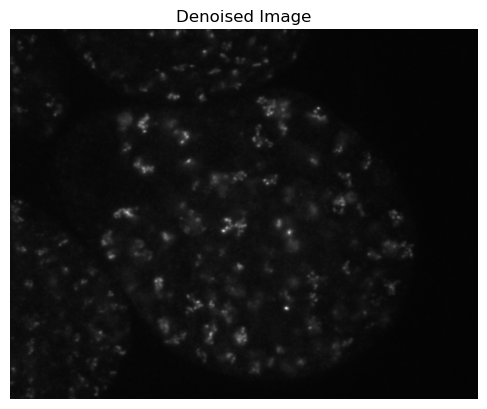

In [46]:
# Plot a single denoised image
denoised_filepath = '/mnt/external.data/MeisterLab/Dario/SDC1/1273/20240813_3d/N2V_sdc1_dpy27_mSG_emr1_mCh/denoised/20240813_1273_E_late_15um_02_n2v.tif'

# Load the image
img_5d = bioio.BioImage(denoised_filepath, reader=bioio_tifffile.Reader)
img = img_5d.get_image_data("ZYXC", T=0, C=spotChannel)

# Plot the image
plt.imshow(img[40], cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()
